In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import requests,json
import os
from dotenv import load_dotenv
%config InlineBackend.figure_format='retina'

from IPython.display import display, HTML
if load_dotenv('../../.env'): print('Succesfully loaded .env')
else: print('Failed to load .env')

Succesfully loaded .env


In [2]:
ffqraw=pd.read_csv('../nhanes-2005-2006/FFQRAW_D.csv',index_col=0)
ffqdc=pd.read_csv('../nhanes-2005-2006/FFQDC_D.csv',index_col=0).drop(columns='FFQ_CODE')
varlook=pd.read_csv('../nhanes-2005-2006/VARLK_D.csv',index_col=0)
foodlook=pd.read_csv('../nhanes-2005-2006/FOODLK_D.csv',index_col=0)

# 1. Create mapping for unique descriptions

In [3]:
unique_descriptions = ffqdc.groupby(['FFQ_VAR','FFQ_FOOD']).size().reset_index().rename(columns={0:'count'})

varlookDict = varlook.set_index('FFQ_VAR').to_dict()['VALUE']
foodlookDict=foodlook.set_index('FFQ_FOOD').to_dict()['VALUE']

unique_descriptions['VARLOOK']=unique_descriptions.apply(lambda x: varlookDict[x['FFQ_VAR']],axis=1)
unique_descriptions['FOODLOOK']=unique_descriptions.apply(lambda x: foodlookDict[x['FFQ_FOOD']],axis=1)

### i. add seasonal weight

In [4]:
def returnSeasonalWeight(e):
    '''
    Daily frequency for a seasonal variable is the daily frequency during that season.
    
    from https://epi.grants.cancer.gov/dhq2/help/faqs.html
    
    Diet*Calc's default settings for when frequency questions are asked for "in season"
    vs. "rest of year," are 1/4 vs 3/4 of a calendar year. For frequency questions asked
    with the terminology "in summer/winter" vs. "rest of year" the settings are 1/3 vs 2/3
    of the year.
    
    (the only winter/summer variables are soup, soda, beer, oatmeal)
    '''
    
    varlook=e['VARLOOK'].lower()
    
    if 'winter' in varlook: return 1/3
    if 'in summer' in varlook: return 1/3
    if 'in season' in varlook: return 1/4
        
    if 'rest of year' in varlook:
        if 'soda' in varlook or 'soup' in varlook or 'beer' in varlook or 'oatmeal' in varlook:
            return 2/3
        else:
            return 3/4
    
    return 1

unique_descriptions['SEASONAL_WEIGHT']=unique_descriptions.apply(returnSeasonalWeight,axis=1)

### ii. return compiled description

In [5]:
def returnDescription(e):
    
    # 1. remove redundant information (if same information is encoded, return the most specific description)
    
    foodlook_only = list(range(0,79+1))+list(range(88,127+1))+[130]+list(range(135,151+1))+list(range(154,159+1))+list(range(162,193+1))+list(range(202,204+1))+list(range(207,214+1))+list(range(219,221+1))+list(range(224,238+1))
    
    compiled=' ' + e['FOODLOOK'] + ' ' # add space at beginning and end to standardize replacements
         
    # 2. convert to lowercase
    
    compiled=compiled.lower()
    
    # 3. remove irrelevant information
    
    def removePhrases(string,phrases):
        returnString=string
        for p in phrases:
            returnString=returnString.replace(p,'')
        return returnString
    
    compiled=removePhrases(compiled,['in cereal','in coffee or tea','to drink','in winter','in the winter','in summer','rest of year','in season','all'])
    
    # 4. format
    compiled=compiled.replace('1/2','half')
    compiled=compiled.replace(' etc','')
    compiled=compiled.replace('/',',')
    compiled=compiled.replace(',',' ')
    compiled=compiled.replace('  ',' ')
    
    # 5. expand abbreviations (for FDC search)
    
    compiled=compiled.replace(' crm ',' cream ')
    compiled=compiled.replace(' cr ',' cream ')
    compiled=compiled.replace(' gr ',' ground ')
    compiled=compiled.replace(' powdrd ',' powdered ')
    compiled=compiled.replace(' reg ',' regular ')
    compiled=compiled.replace(' evap ',' evaporated ')
    compiled=compiled.replace(' cond ',' condensed ')
    compiled=compiled.replace(' repl ',' replacement ')
    compiled=compiled.replace(' ndles ',' noodles ')
    compiled=compiled.replace(' muf ',' muffin ')
    compiled=compiled.replace(' turky ',' turkey ')
    compiled=compiled.replace(' turk ',' turkey ')
    compiled=compiled.replace(' swt ',' sweet ')
    compiled=compiled.replace(' custrd ',' custard ')
    compiled=compiled.replace(' frt ',' fruit ')
    compiled=compiled.replace(' fr ',' french ')
    compiled=compiled.replace(' grpfrt ',' grapefruit ')
    compiled=compiled.replace(' veg ',' vegetable ')
    compiled=compiled.replace(' waff ',' waffle ')
    compiled=compiled.replace(' sug ',' sugar ')
    compiled=compiled.replace(' brkfst ',' breakfast ')
    compiled=compiled.replace(' whlgrn ',' wholegrain ')
    compiled=compiled.replace(' w ',' with ')
    compiled=compiled.replace(' wo ',' without ')
    compiled=compiled.replace(' rav ',' ravioli ')
    compiled=compiled.replace(' jce ',' juice ')
    compiled=compiled.replace(' alc ',' alcohol ')
    compiled=compiled.replace(' bev ',' beverage ')
    compiled=compiled.replace(' othr ',' other ')
    compiled=compiled.replace(' eng ',' english ')
    
    compiled=compiled.replace('regular','')
    
    # 6. remove added whitespace
    
    compiled=compiled.strip()
    
    return compiled

unique_descriptions['DESCRIPTION']=unique_descriptions.apply(returnDescription,axis=1)

In [6]:
IDtoDescription=dict(list(enumerate(unique_descriptions['DESCRIPTION'])))

### iii. create new ID for each unique combination of FOODLOOK, VARLOOK

In [7]:
IDmap={}
for i in unique_descriptions.index:
    e=unique_descriptions.loc[i]
    IDmap[(e['FFQ_VAR'],e['FFQ_FOOD'])]=i

### iv. apply mapping to dataset

In [8]:
def applyMap(start,end):
    for i in list(range(start,end)):
        ffqdc.at[i,'ID']=IDmap[(ffqdc.at[i,'FFQ_VAR'],ffqdc.at[i,'FFQ_FOOD'])]
applyMap(0,len(ffqdc))

In [207]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(unique_descriptions)

,FFQ_VAR,FFQ_FOOD,count,VARLOOK,FOODLOOK,SEASONAL_WEIGHT,DESCRIPTION
0,1.0,130.0,6011,"Tomato Juice, Veg Juice",Tomato/veg juice/ all,1.000000,tomato vegetable juice
1,2.0,128.0,6011,Orange juice or grapefruit juice,Orange/grpfrt jce/ all,1.000000,orange grapefruit juice
2,3.0,129.0,6011,Other fruit juice,Other juice,1.000000,other juice
3,4.0,184.0,5603,"Fruit drinks: Hi-C, lemonade",Fruit drinks/ reg,1.000000,fruit drinks
4,4.0,185.0,1424,"Fruit drinks: Hi-C, lemonade",Frt drinks/ diet,1.000000,fruit drinks diet
5,5.0,12.0,2633,Milk (as a beverage),Milk/ whole to drink,1.000000,milk whole
6,5.0,13.0,2113,Milk (as a beverage),Milk/ 2% to drink,1.000000,milk 2%
7,5.0,14.0,521,Milk (as a beverage),Milk/ 1% to drink,1.000000,milk 1%
8,5.0,15.0,550,Milk (as a beverage),Milk/ nonfat to drink,1.000000,milk nonfat
9,5.0,16.0,91,Milk (as a beverage),Milk/ soy/ to drink,1.000000,milk soy


# 2. Analyze frequency

### i. split dataset into groups using new ID

In [9]:
groups=ffqdc.groupby('ID')

### ii. weigh frequencies by the proportion of individuals in the population reporting

In [10]:
weightedFreq=groups.mean()
weightedFreq['COUNT']=groups.size()
weightedFreq['FFQ_FREQ']=weightedFreq.apply(lambda x: x['FFQ_FREQ']*x['COUNT']/ffqdc['SEQN'].nunique(),axis=1)
weightedFreq.sort_values('FFQ_FREQ',ascending=False,inplace=True)
weightedFreq.reset_index(inplace=True)

labels=list(map(lambda x:IDtoDescription[x],weightedFreq.ID))

### iii. visualize frequency distribution

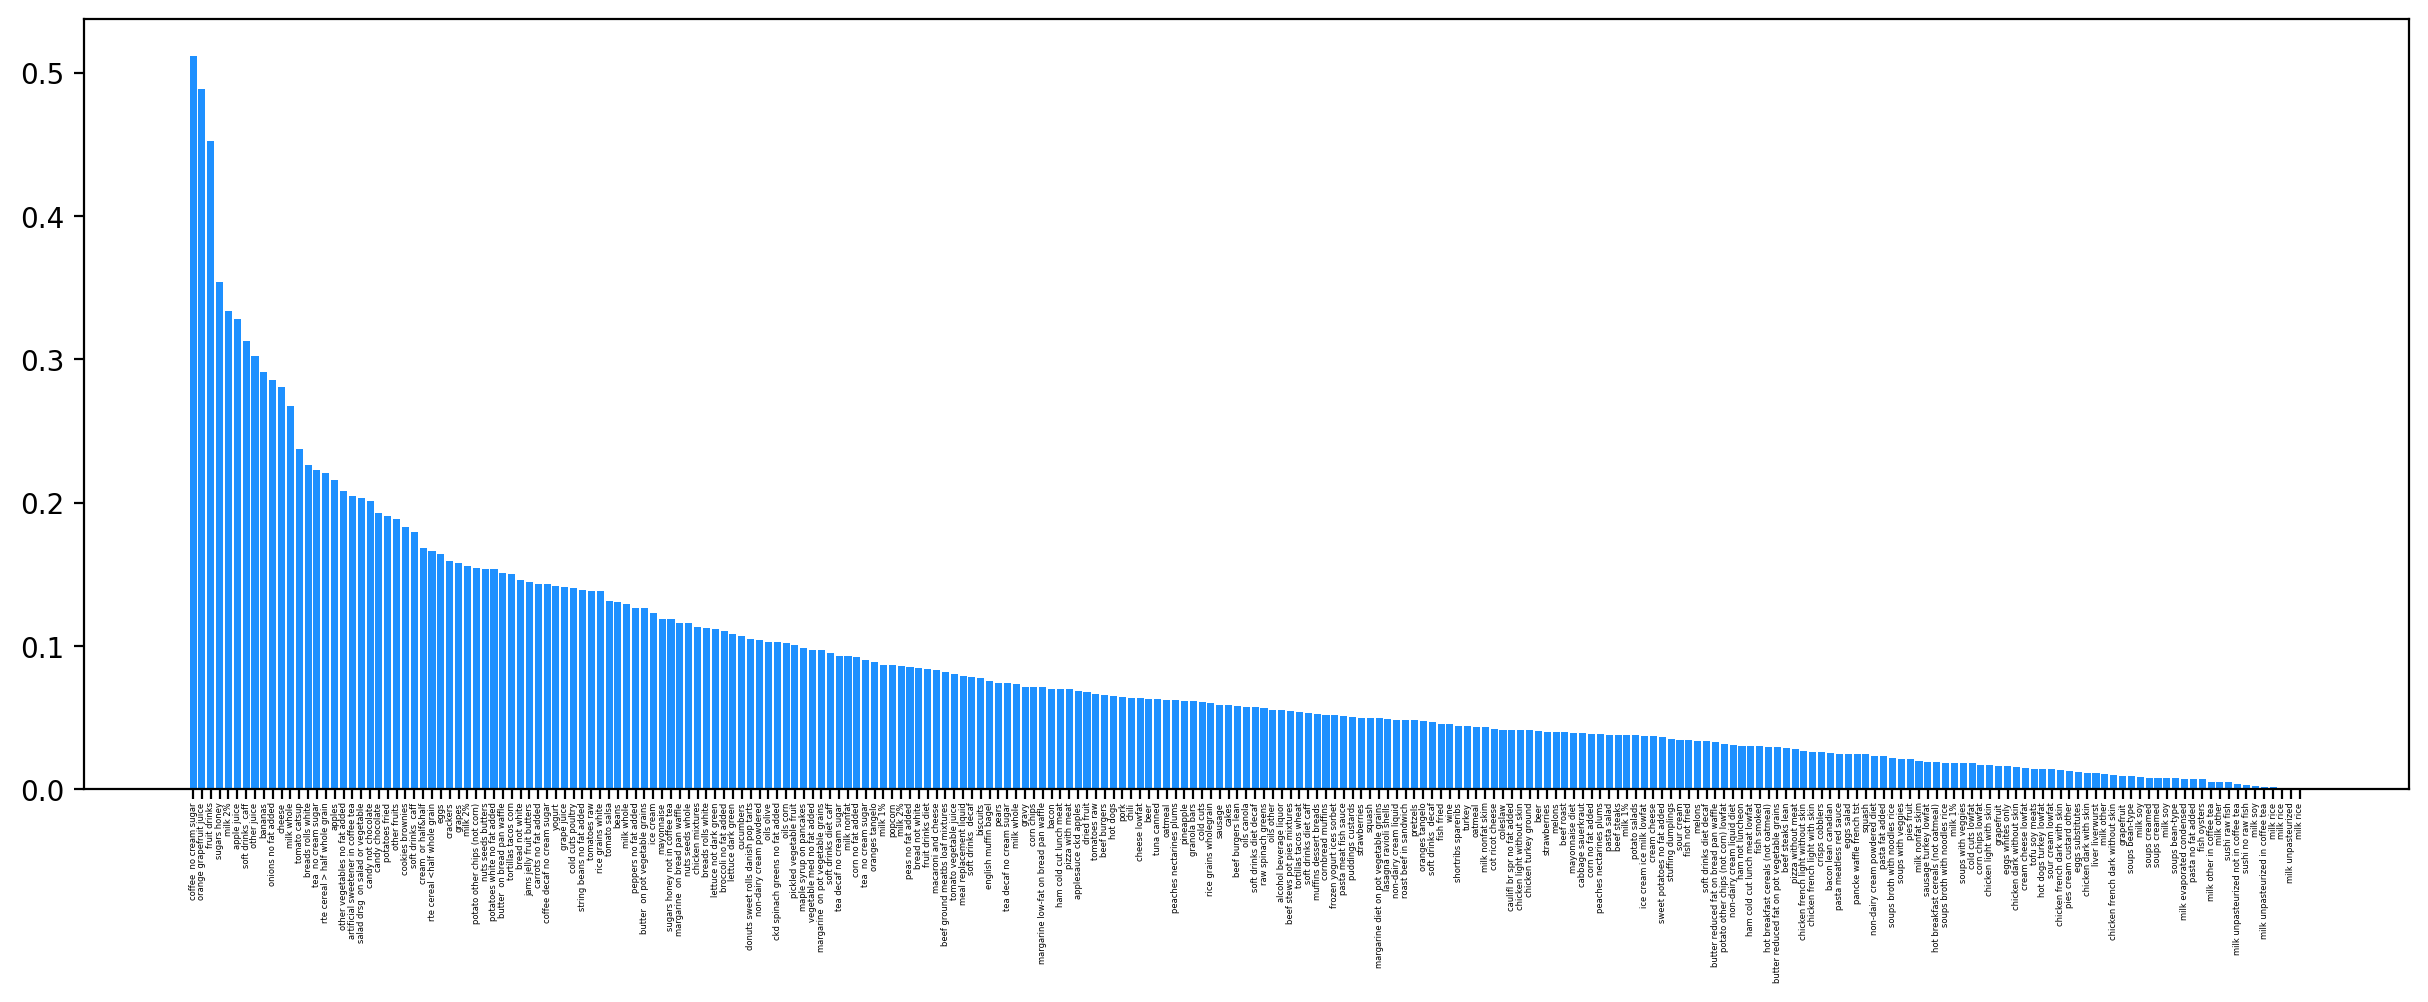

In [11]:
fig,ax=plt.subplots(figsize=(15,5))
ax.bar(weightedFreq.index,weightedFreq['FFQ_FREQ'],color='dodgerblue')

ax.tick_params(axis='x', which='major', labelsize=3)
ax.tick_params(axis='x',pad=1)
ax.tick_params(axis='x',rotation=90)
ax.set_xticks(weightedFreq.index)
ax.set_xticklabels(labels);

#fig.savefig('weightedDescending',dpi=600,bbox_inches="tight")

### iv. identify frequency cutoff for "commonly consumed"

In [35]:
# average length of month = 30.437 days
# cutoff for once a month = 0.03285474915

common = pd.DataFrame(labels[:172],columns=['DESCRIPTION'])

# 3. Compute nutrient percentiles

### i. map most frequently consumed items to FDC entries

In [42]:
def searchFDC(query):
    res=requests.get(f'https://api.nal.usda.gov/fdc/v1/foods/search?api_key={os.environ["REACT_APP_KEY"]}&query={query}').json()['foods']
    first=list(map(lambda e:e['description'],res))[0]
    print(first)
    return first

In [43]:
def fillFDC(start,end):
    for i in list(range(start,end)):
        common.at[i,'FDC']=searchFDC(common.at[i,'DESCRIPTION'])
#fillFDC(0,len(common))

In [57]:
fdc_preliminary=pd.read_csv('frequent_fdc_preliminary.csv',index_col=0)

### ii. remove entries that are composed of multiple foods

In [62]:
fdc_preliminary.drop(index=[15],inplace=True)

In [63]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(fdc_preliminary)

,DESCRIPTION,FDC
0,coffee no cream sugar,"Coffee, pre-sweetened with sugar"
1,orange grapefruit juice,"Orange-grapefruit juice, canned or bottled, unsweetened"
2,fruit drinks,FRUIT DRINKS
3,sugars honey,Honey
4,milk 2%,"Milk, reduced fat (2%)"
5,apple juice,APPLE JUICE
6,soft drinks caff,"Soft drink, cola"
7,other juice,"Chicken ""wings"" with other sauces or seasoning, from other sources"
8,bananas,"Bananas, dehydrated, or banana powder"
9,onions no fat added,"Onions, cooked, fat added"
